# Installing and Imports libraries

In [1]:
#%pip install pylab

In [2]:
# Imports
import numpy as np
import pandas as pd
from itertools import combinations
from scipy.stats import ttest_ind
import os
import sys
import PIL
import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# plt
import matplotlib.pyplot as plt

# graphs in svg looks more fine
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

# printing versions of numpy and python
print('Python         :', sys.version.split('\n')[0])
print('Numpy          :', np.__version__)

Python         : 3.10.10 (tags/v3.10.10:aad5f6a, Feb  7 2023, 17:20:36) [MSC v.1929 64 bit (AMD64)]
Numpy          : 1.24.2


In [3]:
# Imports of local libs
sys.path.insert(1, '../')

from utils.paths import create_paths
from utils.read_config import config_reader

from utils.eda_functions import make_unzip, get_translite
from utils.eda_functions import pre_an_types_feat, prints_types_feat
from utils.eda_functions import col_preanalisys, numb_type_analisys
from utils.eda_functions import plot_col, get_boxplot, get_stat_dif

from utils.nbook_functions import prepare_vladenie, ch_name_col

In [4]:
# read defined params
config = config_reader('../config/data_config.json')
paths = create_paths(config)

# fix RANDOM_SEED for repeating results
RANDOM_SEED = config.RANDOM_SEED
np.random.seed(RANDOM_SEED)

## Reading Data

In [5]:
# unzip data
is_unzip = False
make_unzip(paths.PATH_TO_ZIP, paths.PATH_DATA, is_unzip=is_unzip)

Zip-archive "sf-dst-car-price-prediction-part2.zip" no need to unpack, to unpack change value of param "is_unzip" to "True"


In [6]:
# Reading '.cvs' data files
train = pd.read_csv(os.path.join(paths.PATH_DATA, 'train.csv'))
test = pd.read_csv(os.path.join(paths.PATH_DATA, 'test.csv'))
sample_submission = pd.read_csv(os.path.join(paths.PATH_DATA, 'sample_submission.csv'))

# Let's look at the train data set columns
print(train.columns)

Index(['bodyType', 'brand', 'color', 'description', 'engineDisplacement',
       'enginePower', 'fuelType', 'mileage', 'modelDate', 'model_info', 'name',
       'numberOfDoors', 'price', 'productionDate', 'sell_id',
       'vehicleConfiguration', 'vehicleTransmission', 'Владельцы', 'Владение',
       'ПТС', 'Привод', 'Руль'],
      dtype='object')


In [7]:
train.sample(2)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
1772,седан,MERCEDES,чёрный,Состояние нового автомобиля.,5.5 LTR,585 N12,бензин,2900,2013,S_KLASSE_AMG,...,7100000.0,2016,1100165184,SEDAN AUTOMATIC 5.5,автоматическая,1 владелец,2 года и 6 месяцев,Оригинал,полный,Левый
4813,хэтчбек 5 дв.,AUDI,красный,При покупке автомобиля:\n► Возможна покупка ав...,2.0 LTR,150 N12,бензин,224000,2004,A3,...,389000.0,2005,1099744048,HATCHBACK_5_DOORS AUTOMATIC 2.0,автоматическая,3 или более,NaN,Оригинал,передний,Левый


In [8]:
#translite_columns = [get_translite(x) for x in train.columns]
#train.columns = translite_columns
#train.head(3)

In [9]:
# Comparison of the number of columns in training and test datasets
print(f'Num train cols: {len(train.columns)}, ', f'Num test cols: {len(test.columns)}')
print(f'Col not in test: {set(train.columns) - set(test.columns)}')

# Col with name 'price' - its a target

Num train cols: 22,  Num test cols: 21
Col not in test: {'price'}


In [10]:
# print info about train dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [11]:
# print info about test dataset
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1671 entries, 0 to 1670
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              1671 non-null   object
 1   brand                 1671 non-null   object
 2   color                 1671 non-null   object
 3   description           1671 non-null   object
 4   engineDisplacement    1671 non-null   object
 5   enginePower           1671 non-null   object
 6   fuelType              1671 non-null   object
 7   mileage               1671 non-null   int64 
 8   modelDate             1671 non-null   int64 
 9   model_info            1671 non-null   object
 10  name                  1671 non-null   object
 11  numberOfDoors         1671 non-null   int64 
 12  productionDate        1671 non-null   int64 
 13  sell_id               1671 non-null   int64 
 14  vehicleConfiguration  1671 non-null   object
 15  vehicleTransmission   1671 non-null   

In [11]:
# The number of unique values for each feature
print(train.nunique())

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64


In [12]:
# let's look if the number of unique values in train exceeds that of test
np.sum(train.drop('price', axis=1).nunique() - test.nunique() < 0)

# all values >=0 -> the number of unique values in train not exceed in test

0

In [13]:
# Automatic types of train features pre-analisys
feat_bin, feat_cat, feat_cat_large, feat_other = pre_an_types_feat(train)
prints_types_feat(feat_bin, feat_cat, feat_cat_large, feat_other)

Binary features: 
['ПТС', 'Руль'] 
 ----------------------------------------
Categorical features with 2 < num_cat <= 20: 
['bodyType', 'brand', 'color', 'fuelType', 'numberOfDoors', 'vehicleTransmission', 'Владельцы', 'Привод'] 
 ----------------------------------------
Categorical or num features with unique num of values: 20 < num_cat <= 50: 
['engineDisplacement', 'modelDate', 'productionDate'], 
 ----------------------------------------
Num or other types of features with unique num of values > 50: 
['description', 'enginePower', 'mileage', 'model_info', 'name', 'price', 'sell_id', 'vehicleConfiguration', 'Владение']


In [14]:
# Automatic types of test features pre-analisys
feat_bin, feat_cat, feat_cat_large, feat_other = pre_an_types_feat(test)
prints_types_feat(feat_bin, feat_cat, feat_cat_large, feat_other)

Binary features: 
['ПТС', 'Руль'] 
 ----------------------------------------
Categorical features with 2 < num_cat <= 20: 
['bodyType', 'brand', 'color', 'fuelType', 'numberOfDoors', 'vehicleTransmission', 'Владельцы', 'Привод'] 
 ----------------------------------------
Categorical or num features with unique num of values: 20 < num_cat <= 50: 
['engineDisplacement', 'modelDate', 'productionDate'], 
 ----------------------------------------
Num or other types of features with unique num of values > 50: 
['description', 'enginePower', 'mileage', 'model_info', 'name', 'sell_id', 'vehicleConfiguration', 'Владение']


### Types of features 


<details>
<summary> Display types of all used features </summary> <br>

* bodyType - categorical
* brand - categorical
* color - categorical
* description - text
* engineDisplacement - numeric, represented as text
* enginePower - numeric, represented as text
* fuelType - categorical
* mileage - numeric
* modelDate - numeric or categorical with large num categories
* model_info - categorical
* name - categorical, needs to reduce nums of unique values
* numberOfDoors - categorical
* price - numeric, target
* productionDate - numeric or categorical with large num categories
* sell_id - text, link to images (images are available at the addresses based on sell_id)
* vehicleConfiguration - don't use (cause it's a combination of other columns)
* vehicleTransmission - categorical
* Владельцы - categorical
* Владение - numeric, represented as text
* ПТС - binary
* Привод - categorical
* Руль - binary

Note: Conclusions were done using manual analysis of train and test DataFrames. 
</details>

## EDA

### NaN analisys

In [15]:
# copying train and test
df_train = train.copy()
df_test = test.copy()

In [16]:
# NaN analisys in df_train
mask_train_na = df_train.isna().sum() != 0
print(f'Cols with NaN values in df_train: \n{df_train.isna().sum()[mask_train_na]}')
print('--'*20)

# NaN analisys in df_test
mask_test_na = df_test.isna().sum() != 0
print(f'Cols with NaN values in df_test: \n{df_test.isna().sum()[mask_test_na]}')

Cols with NaN values in df_train: 
Владельцы       1
Владение     4326
dtype: int64
----------------------------------------
Cols with NaN values in df_test: 
Владение    1092
dtype: int64


**df_train**:
1. in **Владение** there are too many NaN the column will be used to create a new attribute: 
    - take into account there is/is not NaN 
    - conversion to a number & if NaN -> replace to 0   
2. One NaN sample in **Владельцы**: 
    - so we can drop it 
    - replace to value '3 или более', cause car 2001 year production -> train.loc[train['Владельцы'].isna(), 'Владельцы'] = '3 или более'

**df_test**:
1. in **Владение** there are too many NaN the column will be used to create a new attribute: 
    - take into account there is/is not NaN 
    - conversion to a number & if NaN -> replace to 0  

In [17]:
print('Before prepare to num feat')
print(df_train['Владение'].head(3))

# prepare feature 'Владение' to num feature
df_train['Владение'] = df_train.Владение.apply(prepare_vladenie)
df_test['Владение'] = df_test.Владение.apply(prepare_vladenie)

print('After prepare to num feat')
print(df_train['Владение'].head(3))

Before prepare to num feat
0                  NaN
1    8 лет и 6 месяцев
2                  NaN
Name: Владение, dtype: object
After prepare to num feat
0      0
1    102
2      0
Name: Владение, dtype: int64


In [18]:
print(len(df_train))
df_train.dropna(subset=['Владельцы'], inplace=True)
print(len(df_train))

6682
6681


### Object columns data pre-analisys

In [19]:
# Names of object features
label_cols = df_train.dtypes[train.dtypes==object].index
print(label_cols)


Index(['bodyType', 'brand', 'color', 'description', 'engineDisplacement',
       'enginePower', 'fuelType', 'model_info', 'name', 'vehicleConfiguration',
       'vehicleTransmission', 'Владельцы', 'Владение', 'ПТС', 'Привод',
       'Руль'],
      dtype='object')


In [20]:
for col in set(label_cols) - set(['description']):
    col_preanalisys(df_train, df_test, col)
print('In other columns all unique values of df_test are contained in df_train')

The numb of unique vals in the name col in df_train >= than in df_test.
 The numb of name vals in df_test that are not present in train: 76
----------------------------------------
The numb of unique vals in the vehicleConfiguration col in df_train >= than in df_test.
 The numb of vehicleConfiguration vals in df_test that are not present in train: 24
----------------------------------------
The numb of unique vals in the model_info col in df_train >= than in df_test.
 The numb of model_info vals in df_test that are not present in train: 4
----------------------------------------
The numb of unique vals in the Владение col in df_train >= than in df_test.
 The numb of Владение vals in df_test that are not present in train: 7
----------------------------------------
The numb of unique vals in the enginePower col in df_train >= than in df_test.
 The numb of enginePower vals in df_test that are not present in train: 8
----------------------------------------
In other columns all unique valu

In [21]:
# Converting the 'name' column to 'ch_name' to exclude data duplicated in other columns
df_train['ch_name'] = df_train.name.apply(ch_name_col)
df_test['ch_name'] = df_test.name.apply(ch_name_col)

# Droping col 'name'
df_train.drop(['name'], axis=1, inplace=True)
df_test.drop(['name'], axis=1, inplace=True)

In [22]:
# bringing all values of the 'engineDisplacement' col to the form 'X.Y LTR'
df_train.engineDisplacement.replace('undefined LTR', '0.0 LTR', inplace=True)
df_test.engineDisplacement.replace('undefined LTR', '0.0 LTR', inplace=True)

# bringing all values of the 'engineDisplacement' col to float value
df_train['ch_engineDisplacement'] = df_train.engineDisplacement.apply(lambda x: float(x[:-4])) 
df_test['ch_engineDisplacement'] = df_test.engineDisplacement.apply(lambda x: float(x[:-4])) 

In [23]:
# bringing all values of the 'enginePower' col to float value
df_train['ch_enginePower'] = df_train.enginePower.apply(lambda x: float(x[:-4]))
df_test['ch_enginePower'] = df_test.enginePower.apply(lambda x: float(x[:-4]))

### EDA numb_cols

In [24]:
# Names of numerical features
num_cols = df_train.dtypes[df_train.dtypes!=object].index
print(num_cols)

Index(['mileage', 'modelDate', 'numberOfDoors', 'price', 'productionDate',
       'sell_id', 'Владение', 'ch_engineDisplacement', 'ch_enginePower'],
      dtype='object')


### **mileage**


 Column: mileage  

Statistical parameters of the column mileage:
25-й percentile: 59144.0, 75-й percentile: 168000.0, IQR: 108856.0,  Boundaries outliers: [-104140.0, 331284.0]. 

There are outliers in the region of maximum values


count      6681.000000
mean     120516.701991
std       81459.112729
min           1.000000
25%       59144.000000
50%      111000.000000
75%      168000.000000
max      999999.000000
Name: mileage, dtype: float64

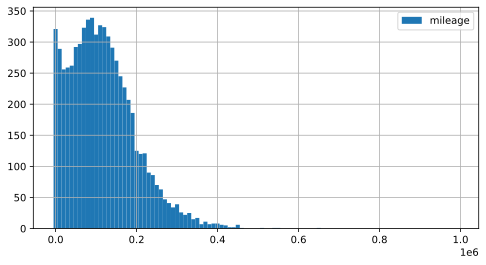

In [25]:
## statistical analisys in col mileage of df_train
col = 'mileage'
numb_type_analisys(df_train, col, 
                   bins_step=(df_train.mileage.max() - df_train.mileage.min())//100)

In [26]:
# Let's see information for car with maximum mileage in df_train
print(df_train[df_train[col]==df_train[col].max()].description.values)
df_train[df_train[col]==df_train[col].max()]

['Рейстайлинг. \nОдин хозяин по ПТС. Оригинальный пробег 98500 км.\n\nСостояние Очень Хорошее ! \nСделано ТО + замена масла в АКПП\nНовая резина !\n\nТехнически и юридически безупречен.\n \nКуплен в августа 2009 , \nБережная эксплуатация и своевременная замена всех расходников. \nВсе системы работают исправно. \nДва ключа. \nМосковские с номера. \nАВТОМОБИЛЬ НЕ ТРЕБУЕТ ВЛОЖЕНИЙ. \nКожанны салон\nПодушки безопасности \nABS EBD ESP \nПарктроник \nТеплый шарф.\nОхранная система \nИммобилайзер \nЦентральный замок\nДатчик света \nДатчик дождя \nОмыватель фар \nКсеноновые фары \nБортовой компьютер \nКруиз контроль \nМультируль \nЭлектропривод богажника \nЭлектрические зеркала с обогревом \nОбогрев сидений \nКлимат контроль 2-зонный \nПротивотуманные фары\nПосредникам, автосалонам и рекламным агентам - просьба не беспокоить.\nТорг.']


,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,ch_name,ch_engineDisplacement,ch_enginePower
1922,родстер,MERCEDES,чёрный,Рейстайлинг. \nОдин хозяин по ПТС. Оригинальны...,1.8 LTR,184 N12,бензин,999999,2008,SLK_KLASSE,...,ROADSTER AUTOMATIC 1.8,автоматическая,1 владелец,131,Оригинал,задний,Левый,200,1.8,184.0


High mileage in cars is not uncommon, so we will not exclude outliers based on the data above. However, there is a clear outlier in the area of maximum values: for a 2008 car, a mileage of 999999 km is indicated. Which is quite a lot. When reading the 'description' it is indicated: "Original mileage 98500 km", which is suspiciously small, but clearly not 999999 km. From here, you can either delete this value or correct it to 98500 or 99999. Let's try the second one (99999), since it is close to 98500 and could have specified an extra digit when filling in the data.

In [27]:
# changing the outlier value to 99999
df_train.loc[df_train[col]==df_train[col].max(), col] = 99999


 Column: mileage  

Statistical parameters of the column mileage:
25-й percentile: 59144.0, 75-й percentile: 168000.0, IQR: 108856.0,  Boundaries outliers: [-104140.0, 331284.0]. 

There are outliers in the region of maximum values


count      6681.000000
mean     120381.991618
std       80745.527022
min           1.000000
25%       59144.000000
50%      111000.000000
75%      168000.000000
max      652000.000000
Name: mileage, dtype: float64

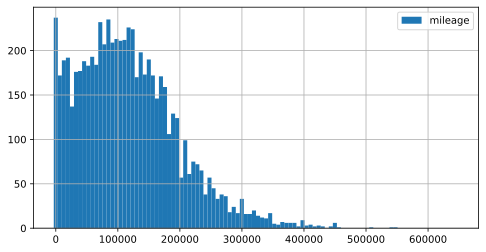

In [28]:
## statistical analisys in col mileage of df_train AGAIN
numb_type_analisys(df_train, col, 
                   bins_step=(df_train[col].max() - df_train[col].min())//100)


 Column: mileage  

Statistical parameters of the column mileage:
25-й percentile: 59373.0, 75-й percentile: 165375.5, IQR: 106002.5,  Boundaries outliers: [-99630.75, 324379.25]. 

There are outliers in the region of maximum values


count       1671.000000
mean      119724.664871
std        83467.240436
min            1.000000
25%        59373.000000
50%       109000.000000
75%       165375.500000
max      1000000.000000
Name: mileage, dtype: float64

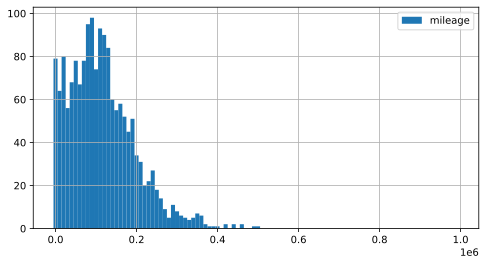

In [29]:
## statistical analisys in col mileage of df_test
numb_type_analisys(df_test, col, 
                   bins_step=(df_test[col].max() - df_test[col].min())//100)

In [30]:
# let's look at the information for car with maximum mileage in df_test
df_test[df_test[col]==df_test[col].max()]

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,ch_name,ch_engineDisplacement,ch_enginePower
960,родстер,MERCEDES,красный,"Обмен не предлагать ,по птс 394 лс",6.0 LTR,394 N12,бензин,1000000,1989,SL_KLASSE,...,ROADSTER AUTOMATIC 6.0,автоматическая,2 владельца,0,Дубликат,задний,Левый,600,6.0,394.0


Only one car in the test set has a mileage of 1,000,000 km and there is no car with a mileage of more than 500,000 km. We change the value of the outlier from 1000000 to 100000, because the presented roadsters of 1989 have runs up to 230000, and also meet with a mileage of 100,000, so a typo in one ign is possible

In [31]:
# changing the outlier value to 100000
test.loc[test['mileage']==test['mileage'].max(), 'mileage'] = 100000
# test.loc[(test['modelDate']<=1995)&(test['brand']=='MERCEDES')&(test['bodyType']=='родстер')]


 Column: mileage  

Statistical parameters of the column mileage:
25-й percentile: 59309.5, 75-й percentile: 165188.25, IQR: 105878.75,  Boundaries outliers: [-99508.625, 324006.375]. 

There are outliers in the region of maximum values


count      1670.000000
mean     119197.553892
std       80662.231754
min           1.000000
25%       59309.500000
50%      109000.000000
75%      165188.250000
max      500000.000000
Name: mileage, dtype: float64

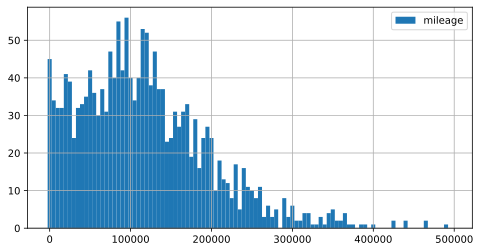

In [32]:
## statistical analisys in col mileage of df_test AGAIN
numb_type_analisys(df_test, col, 
                   bins_step=(df_test[col].max() - df_test[col].min())//100)

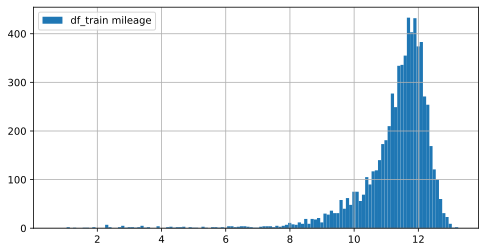

In [33]:
## let's look at the hist of log mileage df_train 
np.log(df_train[col]).hist(bins=np.arange(min(np.log(1 + df_train[col])), 
                                       max(np.log(1 + df_train[col])), 0.1),
                           align='left',
                           label='df_train ' + col)
plt.legend()

# logarithm changes the character of the distribution and reduces the scale of the numerical feature

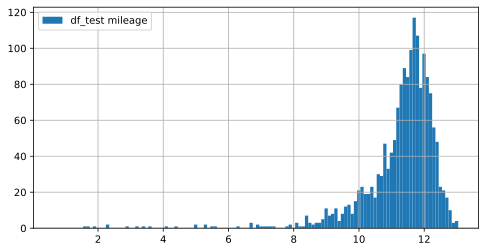

In [34]:
## let's look at the log hist of mileage df_test
np.log(df_test[col]).hist(bins=np.arange(min(np.log(1 + df_test[col])), 
                                       max(np.log(1 + df_test[col])), 0.1),
                           align='left',
                           label='df_test ' + col)
plt.legend()

# logarithm changes the character of the distribution and reduces the scale of the numerical feature

### **modelDate**


 Column: modelDate  

Statistical parameters of the column modelDate:
25-й percentile: 2007.0, 75-й percentile: 2014.0, IQR: 7.0,  Boundaries outliers: [1996.5, 2024.5]. 

There are outliers in the region of minimum values


count    6681.000000
mean     2010.137255
std         5.369647
min      1975.000000
25%      2007.000000
50%      2011.000000
75%      2014.000000
max      2019.000000
Name: modelDate, dtype: float64

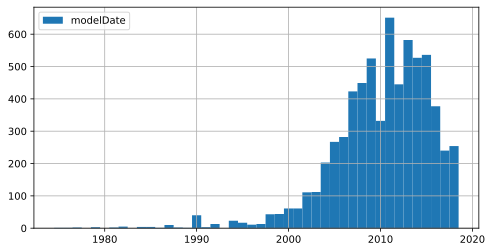

In [35]:
## numb_type_analisys of modelDate df_train
col = 'modelDate'
numb_type_analisys(df_train, col, bins_step=1)

In [36]:
# let's look at the sample with min modelDate df_train
df_train[df_train[col]==df_train[col].min()]

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,ch_name,ch_engineDisplacement,ch_enginePower
3044,седан 2 дв.,BMW,синий,"Состояние близкое к идеальному, все родное, ор...",1.6 LTR,75 N12,бензин,180000,1975,3ER,...,SEDAN_2_DOORS MECHANICAL 1.6,механическая,2 владельца,0,Оригинал,задний,Левый,315,1.6,75.0


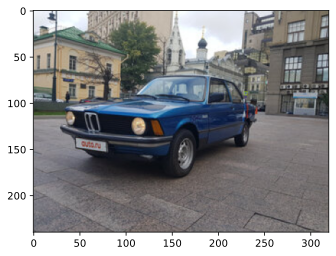

(320, 240)

In [37]:
# let's look at the image with assumed outlier in df_train
image = PIL.Image.open(os.path.join(paths.PATH_DATA_IMGS,
                       str(df_train[df_train[col]==df_train[col].min()].sell_id.values[0]))+\
                       '.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

# Well, it seems that the car, really 1975, we leave =)


 Column: modelDate  

Statistical parameters of the column modelDate:
25-й percentile: 2007.0, 75-й percentile: 2014.0, IQR: 7.0,  Boundaries outliers: [1996.5, 2024.5]. 

There are outliers in the region of minimum values


count    1670.000000
mean     2009.988024
std         5.671334
min      1971.000000
25%      2007.000000
50%      2011.000000
75%      2014.000000
max      2019.000000
Name: modelDate, dtype: float64

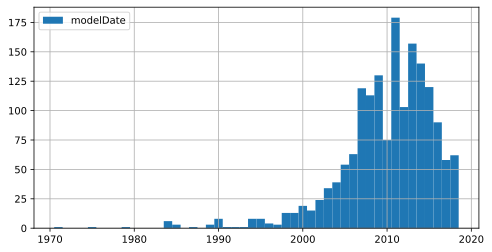

In [38]:
## numb_type_analisys of modelDate test
numb_type_analisys(df_test, col, bins_step=1)

In [39]:
# Let's look for sample with min modelDate df_test
df_test[df_test[col]==df_test[col].min()]

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,ch_name,ch_engineDisplacement,ch_enginePower
428,родстер,MERCEDES,синий,Продаю машину легенду – знаменитый SL в 107 ку...,3.8 LTR,204 N12,бензин,100000,1971,SL_KLASSE,...,ROADSTER AUTOMATIC 3.8,автоматическая,1 владелец,0,Дубликат,задний,Левый,380,3.8,204.0


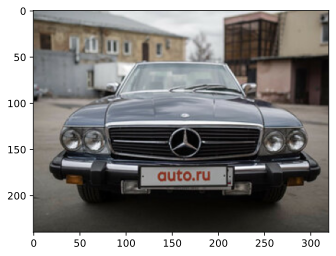

(320, 240)

In [40]:
# let's look at the image with assumed outlier in df_test
image = PIL.Image.open(os.path.join(paths.PATH_DATA_IMGS,
                       str(df_test[df_test[col]==df_test[col].min()].sell_id.values[0]))+\
                       '.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

# And this car looks like a 1971 year car, we leave =)

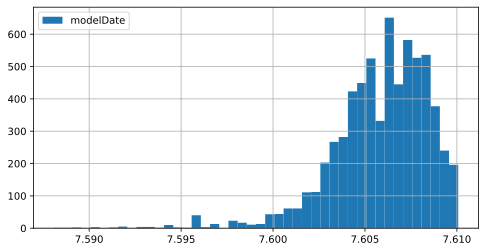

In [41]:
## let's look at the log hist of modelDate df_train
np.log(df_train[col]).hist(bins=np.arange(min(np.log(df_train[col])), 
                                       max(np.log(df_train[col])), 0.0005),
                           align='left',
                           label=col)
plt.legend()

# logarithm does not change much the character of the distribution and reduces the scale of the numerical feature

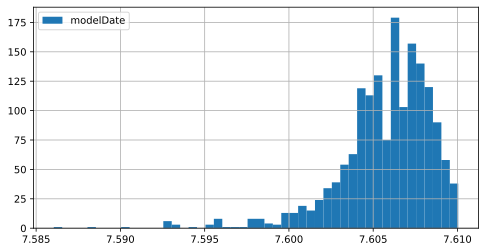

In [42]:
## let's look at the log hist of modelDate df_test 
np.log(df_test[col]).hist(bins=np.arange(min(np.log(df_test[col])), 
                                       max(np.log(df_test[col])), 0.0005),
                           align='left',
                           label=col)
plt.legend()

# logarithm does not change much the character of the distribution and reduces the scale of the numerical feature

### **numberOfDoors**



 Column: numberOfDoors  

Statistical parameters of the column numberOfDoors:
25-й percentile: 4.0, 75-й percentile: 5.0, IQR: 1.0,  Boundaries outliers: [2.5, 6.5]. 

There are outliers in the region of minimum values


count    6681.000000
mean        4.268523
std         0.878747
min         2.000000
25%         4.000000
50%         4.000000
75%         5.000000
max         5.000000
Name: numberOfDoors, dtype: float64

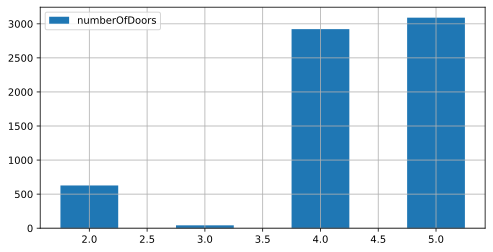

In [43]:
## numb_type_analisys of numberOfDoors df_train
col='numberOfDoors'
numb_type_analisys(df_train, col, bins_step=0.5)


 Column: numberOfDoors  

Statistical parameters of the column numberOfDoors:
25-й percentile: 4.0, 75-й percentile: 5.0, IQR: 1.0,  Boundaries outliers: [2.5, 6.5]. 

There are outliers in the region of minimum values


count    1670.000000
mean        4.237725
std         0.910831
min         2.000000
25%         4.000000
50%         4.000000
75%         5.000000
max         5.000000
Name: numberOfDoors, dtype: float64

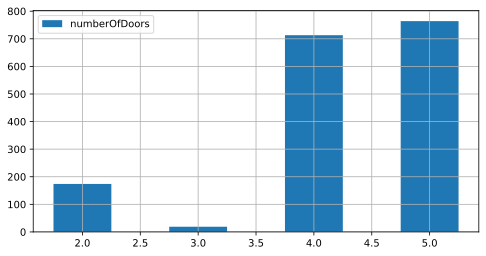

In [44]:
## numb_type_analisys of numberOfDoors df_test
col='numberOfDoors'
numb_type_analisys(df_test, col, bins_step=0.5)

**Conclusions**: The distributions are generally similar, two-door cars are exists, so we think that there are no outliers.

### **productionDate**


 Column: productionDate  

Statistical parameters of the column productionDate:
25-й percentile: 2009.0, 75-й percentile: 2016.0, IQR: 7.0,  Boundaries outliers: [1998.5, 2026.5]. 

There are outliers in the region of minimum values


count    6681.000000
mean     2012.033229
std         5.048250
min      1982.000000
25%      2009.000000
50%      2013.000000
75%      2016.000000
max      2020.000000
Name: productionDate, dtype: float64

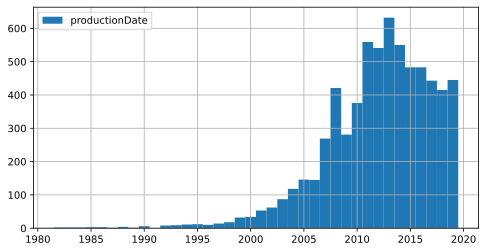

In [45]:
## numb_type_analisys of productionDate df_train
col='productionDate'
numb_type_analisys(df_train, col, bins_step=1)


 Column: productionDate  

Statistical parameters of the column productionDate:
25-й percentile: 2009.0, 75-й percentile: 2016.0, IQR: 7.0,  Boundaries outliers: [1998.5, 2026.5]. 

There are outliers in the region of minimum values


count    1670.000000
mean     2011.938323
std         5.315828
min      1982.000000
25%      2009.000000
50%      2013.000000
75%      2016.000000
max      2020.000000
Name: productionDate, dtype: float64

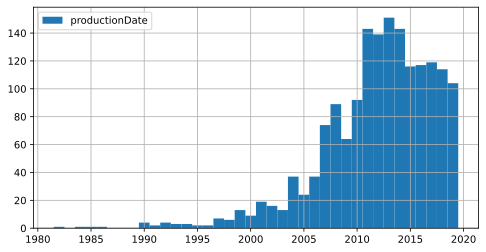

In [46]:
## numb_type_analisys of productionDate df_test
numb_type_analisys(df_test, col, bins_step=1)

**Conclusions:** modelDate & productionDate will be highly correlated and we will drop one

### **Владение**


 Column: Владение  

Statistical parameters of the column Владение:
25-й percentile: 20.0, 75-й percentile: 68.5, IQR: 48.5,  Boundaries outliers: [-52.75, 141.25]. 

There are outliers in the region of maximum values


count    2355.000000
mean       47.733758
std        36.503966
min         1.000000
25%        20.000000
50%        38.000000
75%        68.500000
max       334.000000
Name: Владение, dtype: float64

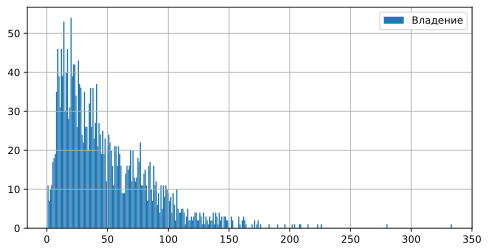

In [47]:
## In the 'Ownership' column of df_train, we exclude rows with values=0, because they are
## artificially created from NaN (we changed NaN to 0) and there are many of them
col='Владение'
numb_type_analisys(df_train[df_train[col]>0], col, bins_step=1)

# It seems that there are no emissions, 
# because the age of the car and the time of ownership may be close to each other
# see. df_train[df_train['Владение']>300]


 Column: Владение  

Statistical parameters of the column Владение:
25-й percentile: 21.0, 75-й percentile: 66.5, IQR: 45.5,  Boundaries outliers: [-47.25, 134.75]. 

There are outliers in the region of maximum values


count    579.000000
mean      47.091537
std       37.748763
min        1.000000
25%       21.000000
50%       37.000000
75%       66.500000
max      355.000000
Name: Владение, dtype: float64

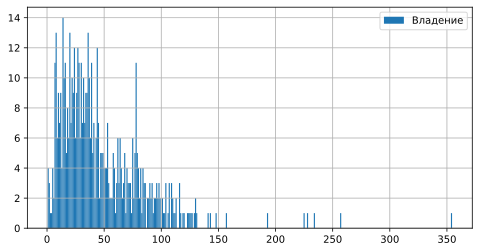

In [48]:
## In the 'Ownership' column of df_train, we exclude rows with values=0, because they are
## artificially created from NaN (we changed NaN to 0) and there are many of them
numb_type_analisys(df_test[df_test['Владение']>0], col, bins_step=1)

# It seems that there are no emissions, 
# because the age of the car and the time of ownership may be close to each other
# see. df_test[df_test['Владение']>300]

## **ch_engineDisplacement**


 Column: ch_engineDisplacement  

Statistical parameters of the column ch_engineDisplacement:
25-й percentile: 2.0, 75-й percentile: 3.0, IQR: 1.0,  Boundaries outliers: [0.5, 4.5]. 

There are outliers in the region of minimum values
There are outliers in the region of maximum values


count    6681.000000
mean        2.781949
std         1.063740
min         0.000000
25%         2.000000
50%         2.800000
75%         3.000000
max         6.600000
Name: ch_engineDisplacement, dtype: float64

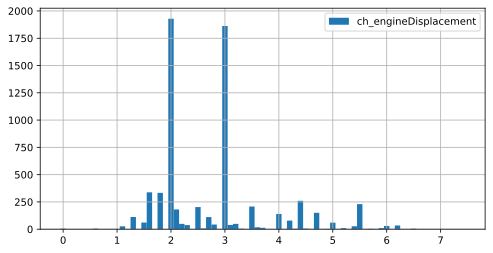

In [49]:
## numb_type_analisys of ch_engineDisplacement df_train
col='ch_engineDisplacement'
numb_type_analisys(df_train, col, bins_step=0.1)

# The result is expected, most of all engines with an engine of 2 and 3 liters
# We accept that there are no outliers


 Column: ch_engineDisplacement  

Statistical parameters of the column ch_engineDisplacement:
25-й percentile: 2.0, 75-й percentile: 3.0, IQR: 1.0,  Boundaries outliers: [0.5, 4.5]. 

There are outliers in the region of minimum values
There are outliers in the region of maximum values


count    1670.000000
mean        2.756647
std         1.033165
min         0.000000
25%         2.000000
50%         2.700000
75%         3.000000
max         6.600000
Name: ch_engineDisplacement, dtype: float64

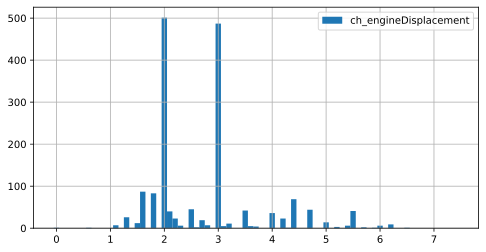

In [50]:
## numb_type_analisys of ch_engineDisplacement df_test
col='ch_engineDisplacement'
numb_type_analisys(df_test, col, bins_step=0.1)

# The result is expected, most of all engines with an engine of 2 and 3 liters
# We accept that there are no outliers

c:\Users\jaffa\Projects\car_price\.venv\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


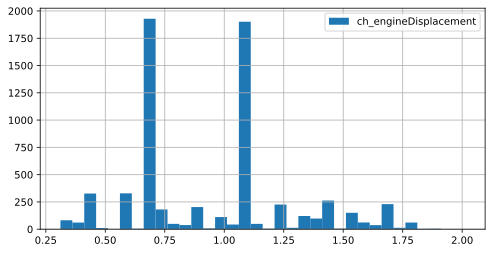

In [51]:
## let's look at the log hist of ch_engineDisplacement df_train 
col = 'ch_engineDisplacement'
np.log(df_train[col]).hist(bins=np.arange(min(np.log(1.4 + df_train[col])), 
                                          max(np.log(1.4 + df_train[col])), 0.05),
                           align='left',
                           label=col)
plt.legend()
# logarithm makes the distribution more symmetrical and reduces the scale

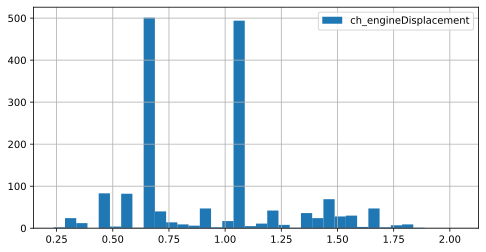

In [52]:
## let's look at the log hist of ch_engineDisplacement df_test 
col = 'ch_engineDisplacement'
np.log(df_test[col]).hist(bins=np.arange(min(np.log(1.3 + df_test[col])), 
                                         max(np.log(1.3 + df_test[col])), 0.05),
                           align='left',
                           label=col)
plt.legend()

# logarithm makes the distribution more symmetrical and reduces the scale

## **ch_enginePower**


 Column: ch_enginePower  

Statistical parameters of the column ch_enginePower:
25-й percentile: 184.0, 75-й percentile: 306.0, IQR: 122.0,  Boundaries outliers: [1.0, 489.0]. 

There are outliers in the region of maximum values


count    6681.000000
mean      255.773088
std       109.240844
min        75.000000
25%       184.000000
50%       231.000000
75%       306.000000
max       639.000000
Name: ch_enginePower, dtype: float64

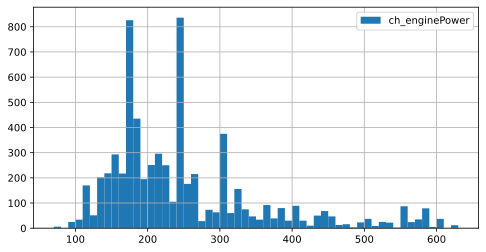

In [53]:
## numb_type_analisys of ch_enginePower df_train
col='ch_enginePower'
numb_type_analisys(df_train, col, bins_step=10)


 Column: ch_enginePower  

Statistical parameters of the column ch_enginePower:
25-й percentile: 184.0, 75-й percentile: 306.0, IQR: 122.0,  Boundaries outliers: [1.0, 489.0]. 

There are outliers in the region of maximum values


count    1670.000000
mean      254.562275
std       107.452954
min       101.000000
25%       184.000000
50%       230.500000
75%       306.000000
max       700.000000
Name: ch_enginePower, dtype: float64

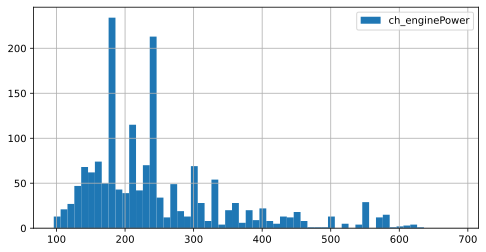

In [54]:
## numb_type_analisys of ch_enginePower df_test
col='ch_enginePower'
numb_type_analisys(df_test, col, bins_step=10)

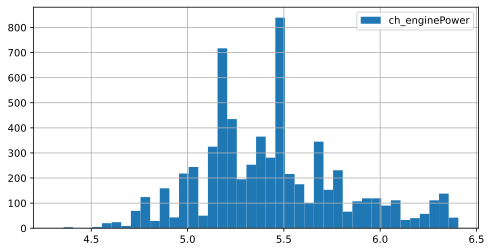

In [55]:
## let's look at the log hist of ch_engineDisplacement df_train 
col = 'ch_enginePower'
np.log(df_train[col]).hist(bins=np.arange(min(np.log(1 + df_train[col])), 
                                          max(np.log(1 + df_train[col])), 0.05),
                           align='left',
                           label=col)
plt.legend()
# logarithm makes the distribution more symmetrical and reduces the scale

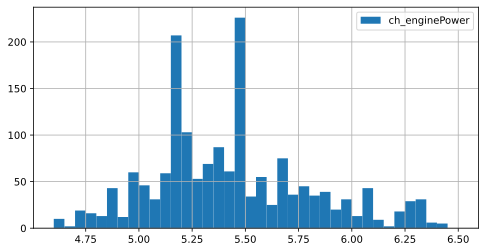

In [56]:
## let's look at the log hist of ch_engineDisplacement df_test
col = 'ch_enginePower'
np.log(df_test[col]).hist(bins=np.arange(min(np.log(1+df_test[col])), 
                                         max(np.log(1+df_test[col])), 0.05),
                           align='left',
                           label=col)
plt.legend()
# logarithm makes the distribution more symmetrical and reduces the scale

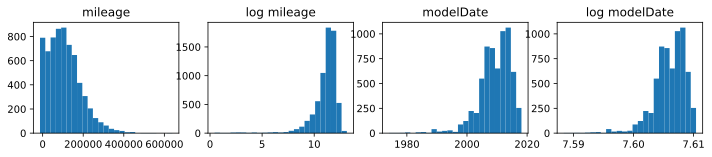

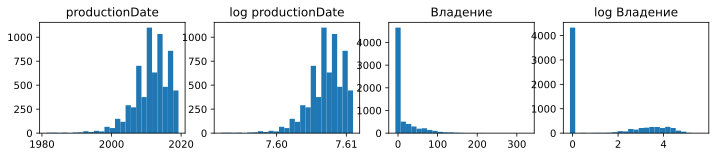

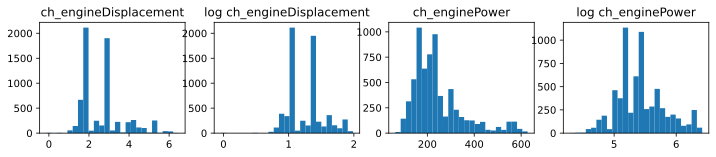

In [57]:
# Let's look again how the graphs change after logarithm

numb_cols = [x for x in df_train.dtypes[df_train.dtypes!=object].index 
             if x not in ['sell_id', 'price', 'numberOfDoors']]

plot_col(numb_cols, df_train)

In [58]:
# let's look at the correlation of numb cols
df_train.corr()

C:\Users\jaffa\AppData\Local\Temp\ipykernel_9792\3930689546.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_train.corr()


,mileage,modelDate,numberOfDoors,price,productionDate,sell_id,Владение,ch_engineDisplacement,ch_enginePower
mileage,1.000000,-0.685423,0.048811,-0.542709,-0.715116,-0.002181,0.103444,0.053405,-0.186831
modelDate,-0.685423,1.000000,0.095043,0.485994,0.963925,0.030155,-0.171923,-0.196112,0.101371
numberOfDoors,0.048811,0.095043,1.000000,0.014990,0.108168,0.020298,-0.032542,-0.005464,-0.030506
price,-0.542709,0.485994,0.014990,1.000000,0.512411,0.024017,-0.102384,0.288457,0.491353
productionDate,-0.715116,0.963925,0.108168,0.512411,1.000000,0.034839,-0.179319,-0.210514,0.085461
sell_id,-0.002181,0.030155,0.020298,0.024017,0.034839,1.000000,-0.070641,-0.006837,-0.001639
Владение,0.103444,-0.171923,-0.032542,-0.102384,-0.179319,-0.070641,1.000000,0.054191,-0.003432
ch_engineDisplacement,0.053405,-0.196112,-0.005464,0.288457,-0.210514,-0.006837,0.054191,1.000000,0.860303
ch_enginePower,-0.186831,0.101371,-0.030506,0.491353,0.085461,-0.001639,-0.003432,0.860303,1.000000


**Conclusions after analysis of numb features**:  
1. **engineDisplacement** and **enginePower** have a strong correlation, it is not recommended to use them at the same time. Due to the fact that **enginePower** has a stronger correlation with price (target variable) than **engineDisplacement**: **enginePower** can be converted into a numeric attribute (+ there are values in the test that are missing in train), and **engineDisplacement** can be left as a categorical attribute.
2. Similarly for **modelDate** and **productionDate**, we try to convert productionDate to a numeric attribute, and exclude modelDate.
3. **mileage** has a strong inverse correlation with modelDate and productionDate. First, let's try to look at the calculated quality.
4. target **price**:
- has a strong direct correlation with **enginePower**, **engineDisplacement**;
- has a strong inverse correlation with **mileage**;
- has a strong direct correlation with **modelDate**, **productionDate**.

In [59]:
# Let's look at the correlation matrix for np.log(df_train). The conclusions are about the same as without np.log
df_train_log = np.log(1 + df_train[df_train.dtypes[df_train.dtypes!=object].index].copy())
df_train_log.corr()

,mileage,modelDate,numberOfDoors,price,productionDate,sell_id,Владение,ch_engineDisplacement,ch_enginePower
mileage,1.000000,-0.524234,0.031291,-0.658707,-0.560211,0.001181,0.078112,0.027280,-0.149686
modelDate,-0.524234,1.000000,0.092204,0.681311,0.963900,0.008810,-0.082678,-0.204003,0.092922
numberOfDoors,0.031291,0.092204,1.000000,0.023560,0.103852,0.016226,-0.043710,-0.002745,-0.032561
price,-0.658707,0.681311,0.023560,1.000000,0.717045,0.009271,-0.053312,0.256779,0.480528
productionDate,-0.560211,0.963900,0.103852,0.717045,1.000000,0.012455,-0.085667,-0.219138,0.073244
sell_id,0.001181,0.008810,0.016226,0.009271,0.012455,1.000000,-0.028408,0.002654,0.000533
Владение,0.078112,-0.082678,-0.043710,-0.053312,-0.085667,-0.028408,1.000000,0.021624,-0.005155
ch_engineDisplacement,0.027280,-0.204003,-0.002745,0.256779,-0.219138,0.002654,0.021624,1.000000,0.868451
ch_enginePower,-0.149686,0.092922,-0.032561,0.480528,0.073244,0.000533,-0.005155,0.868451,1.000000


### Analysis of nominative variables

In [60]:
label_cols = df_train.dtypes[df_train.dtypes==object].index
print(label_cols)

Index(['bodyType', 'brand', 'color', 'description', 'engineDisplacement',
       'enginePower', 'fuelType', 'model_info', 'vehicleConfiguration',
       'vehicleTransmission', 'Владельцы', 'ПТС', 'Привод', 'Руль', 'ch_name'],
      dtype='object')


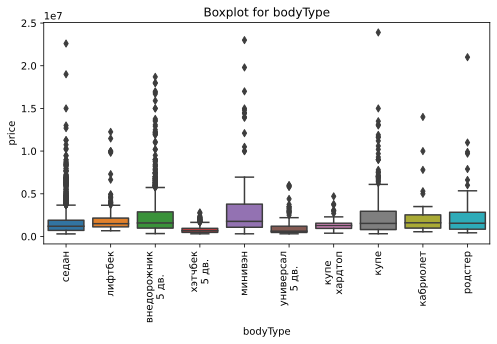

In [61]:
# Boxplots for bodyType of df_train
col = 'bodyType'
# when there are a lot of unuqie values in the column, we select the 10 most common
data = df_train.loc[df_train.loc[:, col].isin(df_train.loc[:, col].value_counts().index[:10])]
get_boxplot(col, data)

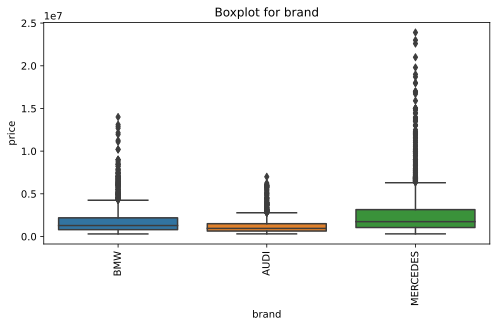

In [62]:
# Boxplots for bodyType of df_train
col = 'brand'
data = df_train.loc[df_train.loc[:, col].isin(df_train.loc[:, col].value_counts().index[:10])]
get_boxplot(col, data)

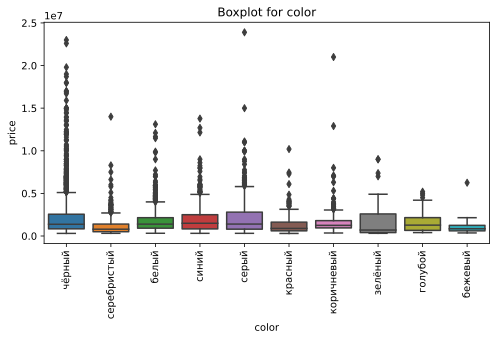

In [63]:
# Boxplots for color of df_train
col = 'color'
data = df_train.loc[df_train.loc[:, col].isin(df_train.loc[:, col].value_counts().index[:10])]
get_boxplot(col, data)

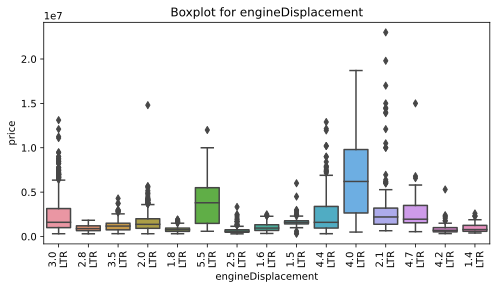

In [64]:
# Boxplots for engineDisplacement of df_train
col = 'engineDisplacement'
data = df_train.loc[df_train.loc[:, col].isin(df_train.loc[:, col].value_counts().index[:15])]
get_boxplot(col, data)

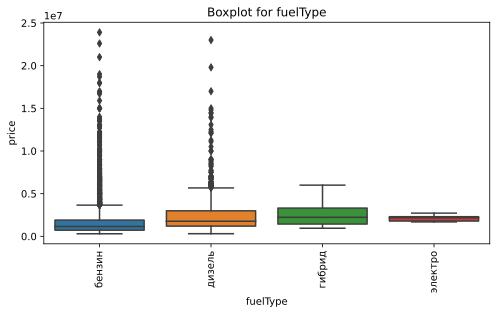

In [65]:
# Boxplots for fuelType of df_train
col = 'fuelType'
data = df_train.loc[df_train.loc[:, col].isin(df_train.loc[:, col].value_counts().index[:10])]
get_boxplot(col, data)

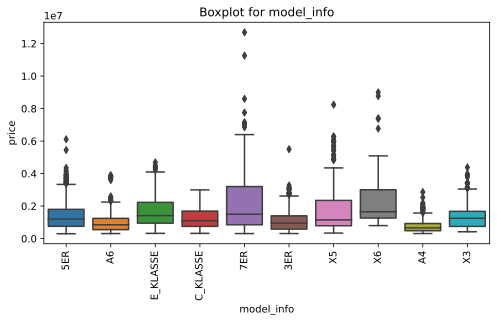

In [66]:
# Boxplots for model_info of df_train
column = 'model_info'
data=df_train.loc[df_train.loc[:, column].isin(df_train.loc[:, column].value_counts().index[:10])]
get_boxplot(column, data)

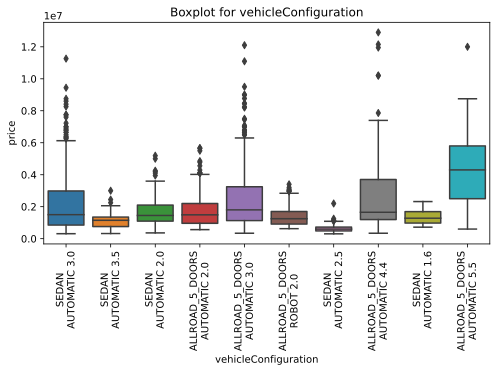

In [67]:
# Boxplots for vehicleConfiguration of df_train
col = 'vehicleConfiguration'
data = df_train.loc[df_train.loc[:, col].isin(df_train.loc[:, col].value_counts().index[:10])]
get_boxplot(col, data)

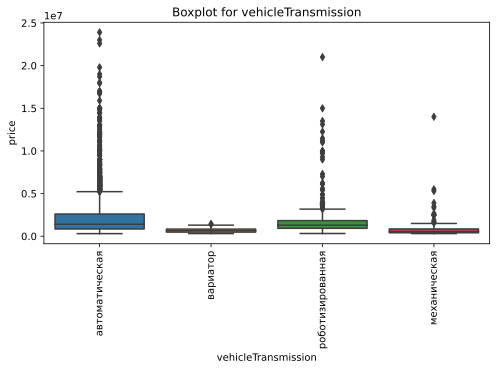

In [68]:
# Boxplots for vehicleTransmission of df_train
col = 'vehicleTransmission'
data = df_train.loc[df_train.loc[:, col].isin(df_train.loc[:, col].value_counts().index[:10])]
get_boxplot(col, data)

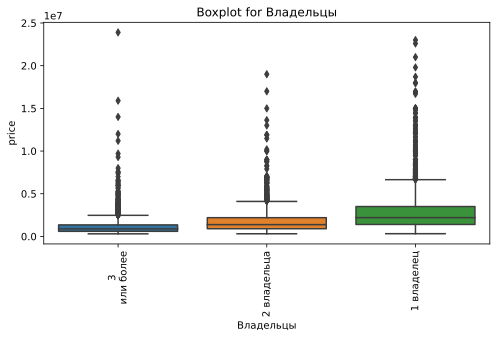

In [69]:
# Boxplots for 'Владельцы' of df_train
column = 'Владельцы'
data = df_train.loc[df_train.loc[:, column].isin(df_train.loc[:, column].value_counts().index[:10])]
get_boxplot(column, data)

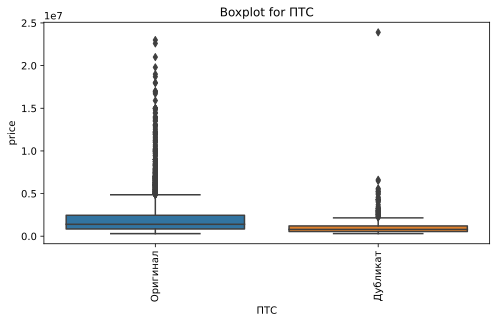

In [70]:
# Boxplots for 'ПТС' of df_train
col = 'ПТС'
data = df_train.loc[df_train.loc[:, col].isin(df_train.loc[:, col].value_counts().index[:10])]
get_boxplot(col, data)

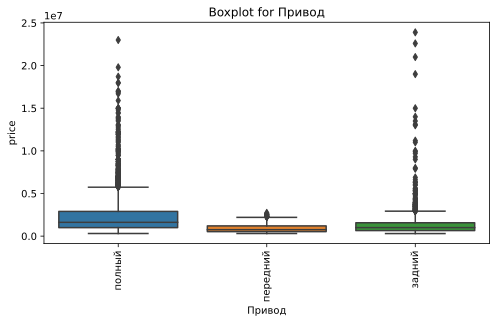

In [71]:
# Boxplots for 'Привод' of df_train
col = 'Привод'
data = df_train.loc[df_train.loc[:, col].isin(df_train.loc[:, col].value_counts().index[:15])]
get_boxplot(col, data)

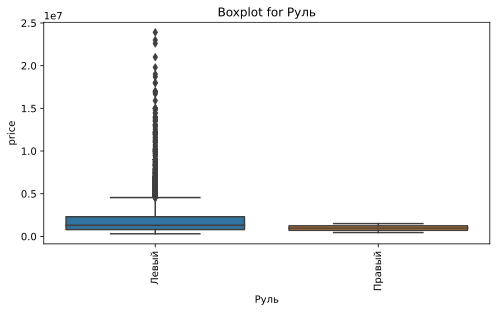

In [72]:
# Boxplots for 'Руль' of df_train
col = 'Руль'
data = df_train.loc[df_train.loc[:, col].isin(df_train.loc[:, col].value_counts().index[:15])]
get_boxplot(col, data)

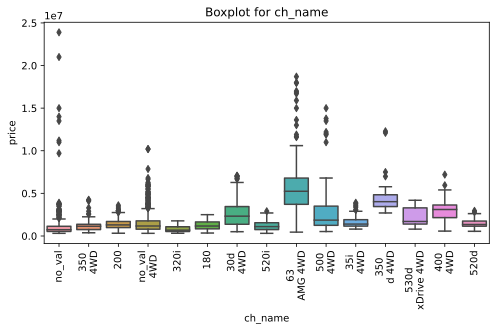

In [73]:
# Boxplots for 'ch_name' of df_train
col = 'ch_name'
data = df_train.loc[df_train.loc[:, col].isin(df_train.loc[:, col].value_counts().index[:15])]
get_boxplot(col, data)

**Conclusions:**  
According to the graphs, it looks like all the parameters can affect the assessment of the cost of a car. Graphs are an auxiliary tool. Let's check if there is a statistical difference in the distribution of the cost of a car by nominative feature, using the Student's test. Let's check the null hypothesis that the distributions of the cost of a car according to various parameters are indistinguishable.

### Checking null hypothesis

In [74]:
# Let's look for value pair combinations for feature 'brand' of df_train
list(combinations(df_train.loc[:, 'brand'].value_counts().index[:], 2))

[('BMW', 'MERCEDES'), ('BMW', 'AUDI'), ('MERCEDES', 'AUDI')]

In [75]:
# testing the null hypothesis with a significance level (alpha) equal to 0.01
for col in list(set(label_cols)-set(['description'])):
    get_stat_dif(col, 0.01, df_train)

Statistically significant differences were found for the column vehicleTransmission with significance level 0.01
Statistically significant differences were found for the column Привод with significance level 0.01
Statistically significant differences were found for the column vehicleConfiguration with significance level 0.01
Statistically significant differences were found for the column brand with significance level 0.01
Statistically significant differences were found for the column fuelType with significance level 0.01
Statistically significant differences were found for the column ПТС with significance level 0.01
Statistically significant differences were found for the column model_info with significance level 0.01
NO statistically significant differences were found for the column ch_name with significance level 0.01
NO statistically significant differences were found for the column Руль with significance level 0.01
Statistically significant differences were found for the column Вл

In [76]:
# testing the null hypothesis with a significance level (alpha) equal to 0.05
for col in list(set(label_cols)-set(['description'])):
    get_stat_dif(col, 0.05, df_train)

Statistically significant differences were found for the column vehicleTransmission with significance level 0.05
Statistically significant differences were found for the column Привод with significance level 0.05
Statistically significant differences were found for the column vehicleConfiguration with significance level 0.05
Statistically significant differences were found for the column brand with significance level 0.05
Statistically significant differences were found for the column fuelType with significance level 0.05
Statistically significant differences were found for the column ПТС with significance level 0.05
Statistically significant differences were found for the column model_info with significance level 0.05
NO statistically significant differences were found for the column ch_name with significance level 0.05
NO statistically significant differences were found for the column Руль with significance level 0.05
Statistically significant differences were found for the column Вл

In [77]:
# testing the null hypothesis with a significance level (alpha) equal to 0.1
for col in list(set(label_cols)-set(['description'])):
    get_stat_dif(col, 0.1, df_train)

Statistically significant differences were found for the column vehicleTransmission with significance level 0.1
Statistically significant differences were found for the column Привод with significance level 0.1
Statistically significant differences were found for the column vehicleConfiguration with significance level 0.1
Statistically significant differences were found for the column brand with significance level 0.1
Statistically significant differences were found for the column fuelType with significance level 0.1
Statistically significant differences were found for the column ПТС with significance level 0.1
Statistically significant differences were found for the column model_info with significance level 0.1
NO statistically significant differences were found for the column ch_name with significance level 0.1
NO statistically significant differences were found for the column Руль with significance level 0.1
Statistically significant differences were found for the column Владельцы w

**Conclusions**:  
based on the statistical analysis carried out to train the model, it is possible to exclude the "Руль" attribute; it is possible to change the transformation of the "name" attribute before finding data from the "name" attribute that will give statistically significant differences when testing the null hypothesis. Otherwise, also exclude this feature.